In [240]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import least_squares, minimize
from sklearn import linear_model
import random
import cma

In [2]:
def f(tc, t, beta):
    return (abs(tc-t))**beta
def g(tc, t, beta, omega):
    return f(tc, t, beta)*np.cos(omega*np.log(abs(tc-t)))
def h(tc, t, beta, omega):
    return f(tc, t, beta)*np.sin(omega*np.log(abs(tc-t)))

In [3]:
def LPPL(t, A, B, C1, C2, beta, omega, tc):
    return A + B*f(tc, t, beta) + C1*g(tc, t, beta, omega) + C2*h(tc, t, beta, omega)

In [4]:
def XOLS(beta, omega, tc, log_price):
    one_col = np.ones(len(log_price))

    t = np.arange(1,len(log_price)+1)
    f_col = f(tc=tc, t=t, beta=beta)
    g_col = g(tc=tc, t=t, beta=beta, omega=omega)
    h_col = h(tc=tc, t=t, beta=beta, omega=omega)

    X = np.array([one_col,f_col,g_col,h_col]).T

    return np.linalg.matrix_rank(X), X

In [5]:
def fit_ABC(beta, omega, tc, log_price):
    r, X = XOLS(beta, omega, tc, log_price)
    if r > 0:
        A, B, C1, C2 = np.linalg.lstsq(X, log_price)[0]
    else:
        #print('rank null')
        A = np.nan
        B = np.nan
        C1 = np.nan
        C2 = np.nan
    return {"A":A, "B":B, "C1":C1, "C2":C2}

In [6]:
def opti_config(log_price):
    beta_m = 0.01
    omega_m = 0

    beta_M = 1.5
    omega_M = 27

    t_first = 0
    t_last = len(log_price)
    t_delta = t_last - t_first
    pct_delta_min = t_delta * 0.2
    pct_delta_max = t_delta * 0.2
    tc_m = t_last - pct_delta_min
    tc_M = t_last + pct_delta_max

    return {"beta_m":beta_m, "omega_m":omega_m, "tc_m":tc_m, "beta_M":beta_M, "omega_M":omega_M, "tc_M":tc_M}

In [7]:
def func_restricted(x, log_price):
    '''
    finds the least square difference
    '''
    tc = x[0]
    beta = x[1]
    omega = x[2]

    fit = fit_ABC(beta, omega, tc, log_price)

    t = np.arange(len(log_price))
    return LPPL(t=t, A=fit['A'], B=fit['B'], C1=fit['C1'], C2=fit['C2'], beta=beta, omega=omega, tc=tc)-log_price

In [8]:
def fit(log_price, max_searches=3):
    config = opti_config(log_price)
    # set random initialization limits for non-linear params
    init_limits = [
        (config['tc_m'], config['tc_M']),  # tc : Critical Time
        (config['beta_m'], config['beta_M']),                
        (config['omega_m'], config['omega_M']),                     
    ]

    search_count = 0
    # find bubble
    sols = []
    normed_residual_min = np.inf
    final_sol = {'tc':np.nan, 'beta':np.nan, 'omega':np.nan, 'A':np.nan, 'B':np.nan, 'C1':np.nan, 'C2':np.nan,'Res':np.nan}
    fun = lambda x: func_restricted(x=x,log_price=log_price)

    while search_count < max_searches:
        #print('search_count' + str(search_count))
        # randomly choose vals within bounds for non-linear params
        rank = 0
        while rank ==0:
            non_lin_vals = [random.uniform(a[0], a[1]) for a in init_limits]
            tc = non_lin_vals[0]
            beta = non_lin_vals[1]
            omega = non_lin_vals[2]
            rank, _ = XOLS(beta, omega, tc, log_price)

        seed = np.array([tc, beta, omega])
        try:
            sol = least_squares(
                fun= fun,
                method='lm',
                x0=seed
            )

            if sol.success:
                tc = sol.x[0]
                beta = sol.x[1]
                omega = sol.x[2]
                # calculate the linear vals again...
                fit_res = fit_ABC(beta, omega, tc, log_price)
                normed_residual = sum(func_restricted(sol.x, log_price)**2)/(7+len(log_price))

                if normed_residual < normed_residual_min:
                    final_sol = {'tc':tc, 'beta':beta, 'omega':omega, 'A':fit_res['A'], 'B':fit_res['B'], 'C1':fit_res['C1'], 'C2':fit_res['C2'],'Res':normed_residual}
                    normed_residual_min = normed_residual
        except Exception as e:
                print('minimize failed: {}'.format(e))
        search_count += 1
    return final_sol

In [136]:
def wrapper_scaling(x,log_price):
    tc_s = x[0]
    beta_s = x[1]
    omega_s = x[2]
    return [len(log_price) + len(log_price)*0.2*np.cos(np.pi*tc_s/10), 1-np.cos(np.pi*beta_s/10), 1 + 49*(1-np.cos(np.pi*omega_s/10))/2]

In [242]:
def fit_cma(log_price):
    init_limits = [
        (4, 6), 
        (0, 5),                
        (1, 3),                     
    ]
    non_lin_vals = [random.uniform(a[0], a[1]) for a in init_limits]
    tc_0 = non_lin_vals[0]
    beta_0 = non_lin_vals[1]
    omega_0 = non_lin_vals[2]
    seed = np.array([tc_0, beta_0, omega_0])
        
    opti_sol = cma.fmin(lambda x: func(x,log_price),sigma0=2,x0=seed, options={ 'popsize':100})
    tc, beta, omega = wrapper_scaling(opti_sol[0],log_price)
    fit_res = fit_ABC(beta, omega, tc, log_price)
    normed_residual = func([tc, beta, omega],log_price)/len(log_price)
    sol = {'tc':tc, 'beta':beta, 'omega':omega, 'A':fit_res['A'], 'B':fit_res['B'], 'C1':fit_res['C1'], 'C2':fit_res['C2'], 'Res':normed_residual}
    return sol


In [129]:
def func(x, log_price):
    '''
    finds the least square difference
    '''
    tc, beta, omega = wrapper_scaling(x,log_price)
    # print('shape: {}'.format(obs.shape))
    fit = fit_ABC(beta, omega, tc, log_price)

    t = np.arange(len(log_price))

    return np.sum((LPPL(t=t, A=fit['A'], B=fit['B'], C1=fit['C1'], C2=fit['C2'], beta=beta, omega=omega, tc=tc)-log_price)**2)

In [9]:
def total_return(log_price):
    price = np.array(np.exp(log_price))
    return (price[-1]-price[0])/price[0]

In [10]:
def get_dt_max(sols, time_windows):
    residuals = [sol['Res'] for sol in sols]
    residuals = pd.DataFrame(residuals).ffill().bfill().values.flatten()
    residuals_lgrn = obtainLagrangeRegularizedNormedCost(residuals, time_windows)
    return time_windows[np.argmin(residuals_lgrn)]


def obtainLagrangeRegularizedNormedCost(residuals, time_windows):
    slope = LagrangeMethod(residuals, time_windows)
    residuals_lgrn = residuals - slope*np.array(list(time_windows))
    return residuals_lgrn

def LagrangeMethod(residuals, time_windows):
    slope = calculate_slope_of_normed_cost(residuals, time_windows)
    return slope[0]

def calculate_slope_of_normed_cost(residuals, time_windows):
    regr =linear_model.LinearRegression(fit_intercept=False)
    x_residuals = np.array(list(time_windows))
    x_residuals = x_residuals.reshape(len(residuals),1)
    res = regr.fit(x_residuals, residuals)
    return res.coef_

In [19]:
def conditions_satisfied(beta, omega, tc, A, B, C1, C2, dt):
    c1 = 0.01 < beta < 1.2
    c2 = 2 < np.abs(omega) < 25
    c3 = 0.95*dt < tc < 1.11*dt
    print('tc in interval: ' + str(c3))
    c4 = 2.5 < np.abs(omega)/(2*np.pi)*np.log(abs(tc/(tc-dt)))
    print('number oscillation: ' + str(c4))
    C = np.sqrt(C1**2+C2**2)
    c5 = 0.8 < beta * abs(B) / (omega * abs(C))
    print('damping: ' + str(c5) )
    return c1 and c2 and c3 and c4 and c5 

In [244]:
def LPPL_confidence(log_price, time_windows):
    
    sols = []
    for dt in time_windows:
        sols.append(fit_cma(log_price[-dt:]))

    dt_max = get_dt_max(sols, time_windows)
    print('dt_max:' + str(dt_max))
    LPPL_confidences = []
    total_returns = []
    for dt in time_windows:
        sol = sols.pop(0)
        if dt <= dt_max: 
            if conditions_satisfied(beta=sol['beta'], omega=sol['omega'], tc=sol['tc'], A=sol['A'], B=sol['B'], C1=sol['C1'], C2=sol['C2'], dt=dt):
                LPPL_confidences.append(1)
                total_returns.append(total_return(log_price[-dt:]))
            else:
                LPPL_confidences.append(0)
                total_returns.append(0)
    print(LPPL_confidences)
    return np.mean(LPPL_confidences)*np.sign(np.median(total_returns))


In [13]:
def LPPL_confidence_signal(log_price, time, time_windows):
    
    LPPL_confidence_ts = []
    for t2 in time:
        print('t2:' + str(t2))
        LPPL_confidence_ts.append(LPPL_confidence(log_price=log_price[:t2], time_windows=time_windows))
    return pd.DataFrame(LPPL_confidence_ts,index=time).fillna(0)

In [14]:
short_dt = range(30,35)
medium_dt = range(91,300)
long_dt = range(301,750)

price = pd.read_csv("data.csv")["Closing Price (USD)"]
log_price = np.log(price)

#LPPL_conf_ts = LPPL_confidence_signal(log_price, time=range(1500,1550), time_windows=np.linspace(50,10,50,dtype=int))

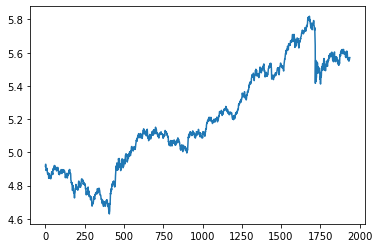

In [220]:
# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
ticker = '^GSPC'

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '1981-01-01'
end_date = '1988-08-30'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader(ticker, 'yahoo', start_date, end_date)
price = panel_data['Adj Close']
log_price = np.log(price)
log_price = log_price.values
plt.plot(log_price)

In [245]:
sig=LPPL_confidence_signal(log_price=log_price, time=range(1650,1700,5), time_windows=range(300,745,5))

alue = 3.772224e-01 3.772224e-01
incumbent solution: [3.3530541316344253, 3.4335000654339245, 2.5644751535523747]
std deviation: [1.2604316364886376e-07, 6.579327721628123e-08, 2.6453285097302278e-08]
(50_w,100)-aCMA-ES (mu_w=27.0,w_1=8%) in dimension 3 (seed=638544, Thu Aug 27 16:25:48 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    100 4.160531326569452e-01 1.0e+00 2.91e+00  2e+00  3e+00 0:00.1
    2    200 7.096709712658611e-01 1.5e+00 3.87e+00  3e+00  4e+00 0:00.1
    3    300 5.936222229523371e-01 1.9e+00 4.15e+00  2e+00  3e+00 0:00.2
   41   4100 3.815335696756311e-01 2.5e+01 6.48e+00  3e-07  1e-06 0:03.2
   45   4500 3.815335696756239e-01 2.1e+01 4.93e+00  3e-08  1e-07 0:03.5
termination on tolfun=1e-11 (Thu Aug 27 16:25:52 2020)
final/bestever f-value = 3.815336e-01 3.815336e-01
incumbent solution: [-3.391538135325662, -3.4439961006920283, 2.556027469762075]
std deviation: [1.3097087133526387e-07, 6.24704161554249e-08, 2.5022434519785795e-

In [ ]:
beta = 0.44
omega = 6.5
C1 = - 0.0001
C2 = 0.0005
A = 1.8259
B = - 0.0094
tc = 805
log_price = LPPL(t=np.arange(800), A=A, B=B, C1=C1, C2=C2, beta=beta, omega=omega, tc=tc)
#log_price = np.append(log_price[300::-1],log_price)
plt.plot(log_price)

(50_w,100)-aCMA-ES (mu_w=27.0,w_1=8%) in dimension 3 (seed=604170, Thu Aug 27 15:15:52 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    100 8.221530279749910e+00 1.0e+00 2.66e+00  2e+00  3e+00 0:00.1
    2    200 1.232993661136534e+01 1.8e+00 2.77e+00  2e+00  3e+00 0:00.2
    3    300 1.054349467075616e+01 2.3e+00 2.88e+00  1e+00  4e+00 0:00.4
   30   3000 1.206012995678168e+01 7.6e+01 9.13e+00  3e-04  2e-02 0:03.4
   56   5600 1.205992540647177e+01 5.6e+02 6.62e+00  1e-10  8e-08 0:06.4
termination on tolfun=1e-11 (Thu Aug 27 15:15:59 2020)
final/bestever f-value = 1.205993e+01 8.221530e+00
incumbent solution: [6.481761284284745, 2.5484658244537965, -0.10850601349048881]
std deviation: [1.3804579248579486e-10, 7.608113394226467e-08, 3.325452809443436e-08]


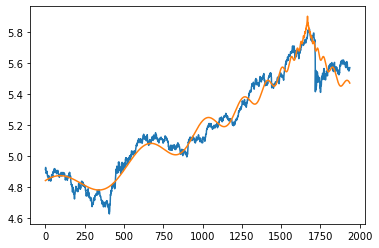

In [243]:

sol = fit_cma(log_price)
plt.plot(log_price)
plt.plot(LPPL(range(len(log_price)), sol['A'], sol['B'], sol['C1'], sol['C2'], sol['beta'], sol['omega'], sol['tc']))